### Note that this is a POC for classification that could help with assigning inputs to groups automatically. 
### The dataset is relatively poor, so faulty results are expected. 


### Imports 

In [4]:
import numpy as np
import pandas as pd
import re
from sklearn.naive_bayes import MultinomialNB
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Data Import and processing

In [5]:
# This function takes care of cleaning data by removing _ and ()
def preprocess_input(word):
    word = re.sub(r'_', ' ', word)
    word = re.sub(r'\(', '', word)
    word = re.sub(r'\)', '', word)
    word = re.sub(r'\.', ' ', word)
    word = re.sub(r"[^\w\s]", "", word)
    word = word.lower()

    return word

#Importing the Dataset
df = pd.read_csv('Groups.csv')
df.head()
df['Groups'].value_counts()
#nltk.download('punkt')

#Processing data ina new data Frame
X= []
X= df['Name'].apply(preprocess_input)
y=[]
y= df['Groups']
groups = pd.DataFrame()
groups['Name']= X
groups['Groups']= y

#Converting input into numerical vectors
vectorizer = CountVectorizer()
vectorizer.fit(groups['Name'])
vector = vectorizer.transform(groups['Name'])

#Applying TFIDF
tfidf_transformer = TfidfTransformer().fit(vector)
input_tfidf= tfidf_transformer.transform(vector)


The TF-IDF representation is used as input because it captures the importance of each word in the dataset, which can help improve the accuracy of the classification model.

#### The distribution of the groups is shown below, this distribution explains the faulty results. 

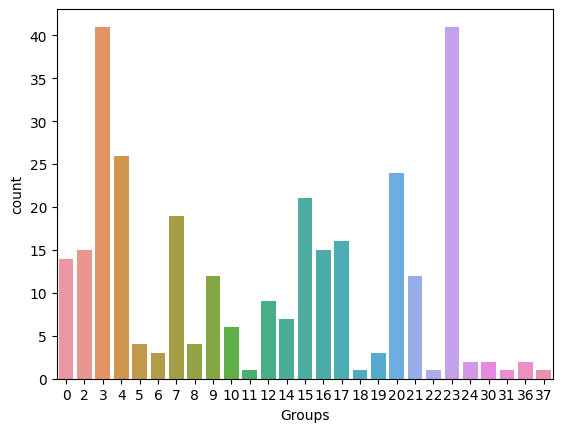

In [6]:
sns.countplot(x='Groups',data=df )
plt.show()

#  MutliNomial Naive Bayes

In [7]:
def MultinomialNBClassify(word):   

    model = MultinomialNB().fit(input_tfidf, df['Groups'])

    all_predictions = model.predict(input_tfidf)

    # Preprocess the input word
    preprocessed_word = preprocess_input(word)

    # Transform the preprocessed word into a vector
    word_vector = vectorizer.transform([preprocessed_word])

    # Apply TF-IDF transformation
    tfidf_word = tfidf_transformer.transform(word_vector)

    # Return the predicted group
    prediction = model.predict(tfidf_word)
    #print(f"Predicted group for '{word}': {prediction[0]}")
    pred= prediction[0]
    return pred


# SVM

In [8]:
def SVMClassifier(word):
    
    X_train, X_test, y_train, y_test = train_test_split(input_tfidf, y, test_size=0.20, random_state=42)

    classifier= svm.SVC(kernel='linear', gamma='auto', C=3)
    classifier.fit(X_train,y_train)
    y_pred= classifier.predict(X_test)
    
    # Preprocess the input word
    preprocessed_word = preprocess_input(word)

    # Transform the preprocessed word into a vector
    word_vector = vectorizer.transform([preprocessed_word])

    # Apply TF-IDF transformation
    tfidf_word = tfidf_transformer.transform(word_vector)

    # Return the predicted group
    prediction = classifier.predict(tfidf_word)
    #print(f"Predicted group for '{word}': {prediction[0]}")
    pred= prediction[0]
    return pred


### functions

In [9]:

def ClassifierNB(file):
    df = pd.read_csv(file)
    inputs = df.columns.tolist()
    print(inputs)
    NB= []
    for word in inputs :
        new = preprocess_input(word)
        n = MultinomialNBClassify(new)
        NB.append(n)
    return NB

def  ClassifierSVM(file):
    df = pd.read_csv(file)
    inputs = df.columns.tolist()
    print(inputs)

    SVM = []
    for word in inputs :
        new = preprocess_input(word)
        n= SVMClassifier(new)
        SVM.append(n)
    return SVM

#### Tests

In [10]:
word0= 'TV Ad'
testing = MultinomialNBClassify(word0)
word1='Unemployment Rate'
test= SVMClassifier(word1)

print(f"Predicted group for '{word0}': {testing}")
print(f"Predicted group for '{word1}': {test}")

Predicted group for 'TV Ad': 21
Predicted group for 'Unemployment Rate': 4


In [11]:
print(ClassifierNB('Test.csv'))

['TV Ad ($)', 'Radio Ads ($)', 'Press  Ads', 'Social Media Advertisement ($)']
[21, 23, 15, 20]


In [12]:
print(ClassifierSVM('Test.csv'))

['TV Ad ($)', 'Radio Ads ($)', 'Press  Ads', 'Social Media Advertisement ($)']
[21, 8, 15, 20]


### trial: Implement NLP - Keras 

In [24]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

In [12]:
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = set(stopwords.words("english"))

def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\21628\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [14]:
X = X.map(remove_stopwords)

In [16]:
from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count


counter = counter_word(X)

In [17]:
len(counter)

365

In [20]:
num_unique_words = len(counter)

In [22]:
# Split dataset into training and validation set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# split text and labels
train_sentences = X_train.to_numpy()
train_labels = y_train.to_numpy()
val_sentences = X_test.to_numpy()
val_labels = y_test.to_numpy()

In [24]:
# Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

# vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences) # fit only to training

In [25]:
# each word has unique index
word_index = tokenizer.word_index

In [26]:
word_index

{'spend': 1,
 'marketing': 2,
 'investment': 3,
 'press': 4,
 'sales': 5,
 'rate': 6,
 'store': 7,
 'online': 8,
 'tv': 9,
 'index': 10,
 'day': 11,
 'mrp': 12,
 'percentage': 13,
 'box': 14,
 'office': 15,
 'discount': 16,
 'promo': 17,
 'paid': 18,
 'bv': 19,
 '2': 20,
 'cc': 21,
 'social': 22,
 'media': 23,
 'advertising': 24,
 'direct': 25,
 'mail': 26,
 'value': 27,
 'trade': 28,
 'price': 29,
 'search': 30,
 'product': 31,
 'winter': 32,
 'distribution': 33,
 'digital': 34,
 'money': 35,
 'competitor': 36,
 'retail': 37,
 'revenue': 38,
 'stores': 39,
 'radio': 40,
 'total': 41,
 'content': 42,
 'screen': 43,
 'distribtion': 44,
 'promotion': 45,
 'multibuy': 46,
 'sponsorship': 47,
 'gross': 48,
 'google': 49,
 'ad': 50,
 'print': 51,
 'covid': 52,
 'views': 53,
 'facebook': 54,
 'magazines': 55,
 'audience': 56,
 'retention': 57,
 'cameraaccessory': 58,
 'catalog': 59,
 'customer': 60,
 'lifetime': 61,
 'summer': 62,
 'entertainmentsmall': 63,
 'event': 64,
 'participation': 65

In [27]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

In [221]:
# Pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Max number of words in a sequence
max_length = 5

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")
train_padded.shape, val_padded.shape

((242, 5), (61, 5))

In [222]:
train_padded[2]

array([54,  0,  0,  0,  0])

In [223]:
print(train_sentences[2])
print(train_sequences[2])
print(train_padded[2])

facebook
[54]
[54  0  0  0  0]


In [224]:
# Check reversing the indices

# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [225]:
reverse_word_index

{1: 'spend',
 2: 'marketing',
 3: 'investment',
 4: 'press',
 5: 'sales',
 6: 'rate',
 7: 'store',
 8: 'online',
 9: 'tv',
 10: 'index',
 11: 'day',
 12: 'mrp',
 13: 'percentage',
 14: 'box',
 15: 'office',
 16: 'discount',
 17: 'promo',
 18: 'paid',
 19: 'bv',
 20: '2',
 21: 'cc',
 22: 'social',
 23: 'media',
 24: 'advertising',
 25: 'direct',
 26: 'mail',
 27: 'value',
 28: 'trade',
 29: 'price',
 30: 'search',
 31: 'product',
 32: 'winter',
 33: 'distribution',
 34: 'digital',
 35: 'money',
 36: 'competitor',
 37: 'retail',
 38: 'revenue',
 39: 'stores',
 40: 'radio',
 41: 'total',
 42: 'content',
 43: 'screen',
 44: 'distribtion',
 45: 'promotion',
 46: 'multibuy',
 47: 'sponsorship',
 48: 'gross',
 49: 'google',
 50: 'ad',
 51: 'print',
 52: 'covid',
 53: 'views',
 54: 'facebook',
 55: 'magazines',
 56: 'audience',
 57: 'retention',
 58: 'cameraaccessory',
 59: 'catalog',
 60: 'customer',
 61: 'lifetime',
 62: 'summer',
 63: 'entertainmentsmall',
 64: 'event',
 65: 'participation'

In [226]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

In [227]:
decoded_text = decode(train_sequences[2])

print(train_sequences[2])
print(decoded_text)

[54]
facebook


In [246]:
# Create LSTM model
from tensorflow.keras import layers

# Embedding: https://www.tensorflow.org/tutorials/text/word_embeddings
# Turns positive integers (indexes) into dense vectors of fixed size. (other approach could be one-hot-encoding)

# Word embeddings give us a way to use an efficient, dense representation in which similar words have 
# a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a 
# dense vector of floating point values (the length of the vector is a parameter you specify).

model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 16,  input_length=max_length))

# The layer will take as input an integer matrix of size (batch, input_length),
# and the largest integer (i.e. word index) in the input should be no larger than num_words (vocabulary size).
# Now model.output_shape is (None, input_length, 32), where `None` is the batch dimension.


model.add(layers.LSTM(16, dropout=0.1))
model.add(layers.Dense(1, activation="sigmoid"))

#model.add(layers.Dense(2, activation='softsign'))
#model.add(layers.Dropout(0.2))
#m#odel.add(layers.Dense(8, activation='selu'))
#model.add(layers.LSTM(2, dropout=0.1))
#model.add(layers.Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_59 (Embedding)    (None, 5, 16)             5840      
                                                                 
 lstm_48 (LSTM)              (None, 16)                2112      
                                                                 
 dense_124 (Dense)           (None, 1)                 17        
                                                                 
Total params: 7969 (31.13 KB)
Trainable params: 7969 (31.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [247]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optim, metrics=metrics)


In [248]:
    model.fit(train_padded, train_labels, epochs=1, validation_data=(val_padded, val_labels), verbose=2)

8/8 - 2s - loss: 0.4456 - accuracy: 0.0124 - val_loss: -2.1320e-02 - val_accuracy: 0.0000e+00 - 2s/epoch - 228ms/step


In [235]:
predictions = model.predict(train_padded)
predictions = [1 if p > 0.5 else 0 for p in predictions]

8/8 [==============================] - 0s 2ms/step


In [236]:
print(train_sentences[10:20])

print(train_labels[10:20])
print(predictions[10:20])

['customer lifetime value clv' 'internationals womens day'
 'trade shows exhibitions' 'summer solstice' 'radio investment'
 'pinterest' 'facebook' 'twitter' 'flyers' 'mrp entertainmentsmall']
[ 2 23  3 23  8 20 21 20 15 16]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [25]:
from tensorflow import keras
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

ImportError: cannot import name '__version__' from 'tensorflow.keras' (C:\Users\21628\anaconda3\Lib\site-packages\keras\api\_v2\keras\__init__.py)

In [26]:
import sys

print(sys.version)


3.11.3 | packaged by Anaconda, Inc. | (main, Apr 19 2023, 23:46:34) [MSC v.1916 64 bit (AMD64)]


In [13]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=42 )

In [16]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [22]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dense(4, activation='selu', name="output")(l)
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [24]:
len(X_train)

242

In [25]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [26]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
8/8 [==============================] - 31s 4s/step - loss: -30.7387 - accuracy: 0.0000e+00 - precision: 0.9545 - recall: 1.0000
Epoch 2/5
8/8 [==============================] - 29s 4s/step - loss: -65.6349 - accuracy: 0.0000e+00 - precision: 0.9545 - recall: 1.0000
Epoch 3/5
8/8 [==============================] - 29s 4s/step - loss: -101.6709 - accuracy: 0.0000e+00 - precision: 0.9545 - recall: 1.0000
Epoch 4/5
8/8 [==============================] - 29s 4s/step - loss: -136.7372 - accuracy: 0.0000e+00 - precision: 0.9545 - recall: 1.0000
Epoch 5/5
8/8 [==============================] - 32s 4s/step - loss: -171.4163 - accuracy: 0.0000e+00 - precision: 0.9545 - recall: 1.0000
